<a href="https://colab.research.google.com/github/victorvalente/HarmonicOscillatorPSO/blob/main/HarmonicOscillatorPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading SPHERE dataset from: ./sphere_dataset/
Data loading complete.
Training the swarm intelligence system...
Running swarm simulation with 8 agents...
Processed window 1/50
Processed window 21/50
Processed window 41/50
Simulation complete.

Evaluating performance...
Evaluation complete. Accuracy: 32.50%


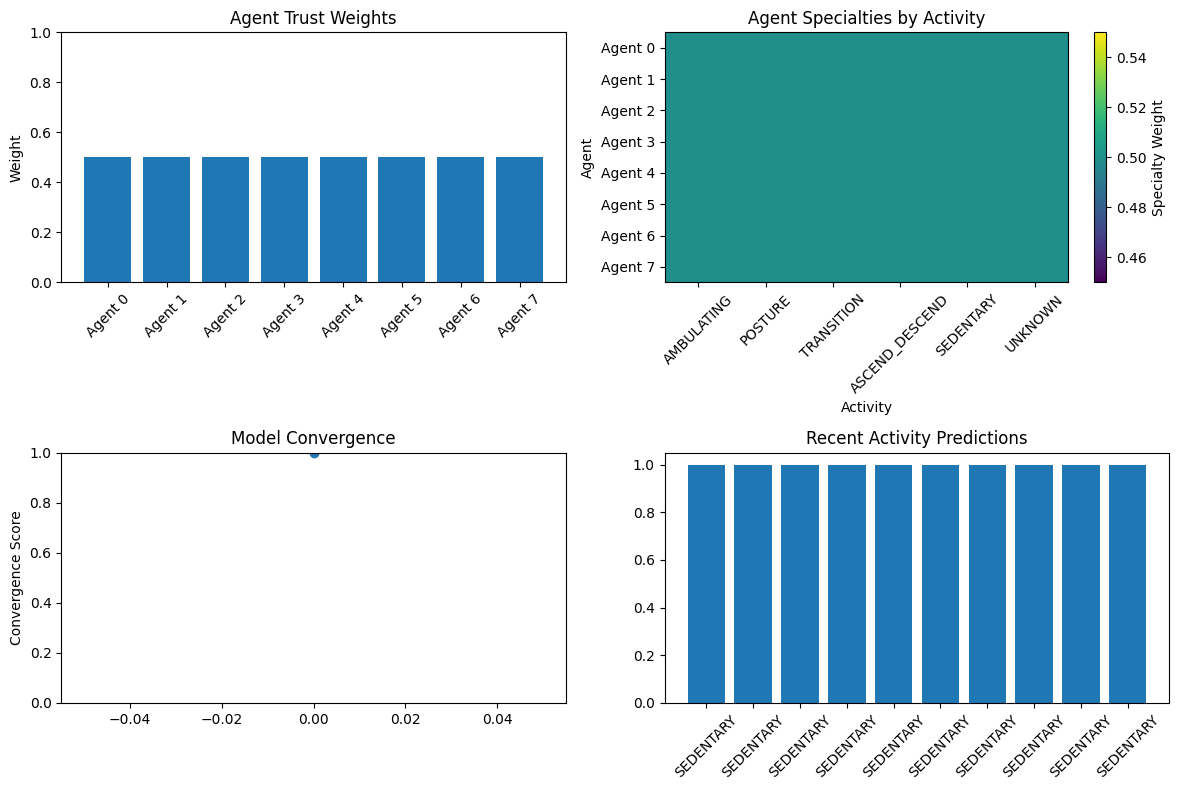


Running in prediction mode...
Running swarm simulation with 8 agents...
Processed window 1/20
Simulation complete.
Simulation completed successfully.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from enum import Enum, auto
import os
import glob
import json
from collections import defaultdict

class SensorType(Enum):
    """Different types of sensory capabilities for agents in SPHERE dataset"""
    ACCELEROMETER = auto()  # Wearable accelerometer data
    ENVIRONMENTAL = auto()  # PIR sensors, temperature, etc.
    VIDEO_FEATURES = auto()  # Features extracted from video (anonymized)
    RSSI = auto()  # Signal strength data

class Activity(Enum):
    """Activities to recognize from SPHERE dataset"""
    AMBULATING = 1   # walking, running, etc.
    POSTURE = 2      # sitting, standing, etc.
    TRANSITION = 3   # changing position
    ASCEND_DESCEND = 4  # stairs
    SEDENTARY = 5    # reading, watching TV, etc.
    UNKNOWN = 0

class Location(Enum):
    """Locations in the SPHERE house"""
    KITCHEN = auto()
    LIVING_ROOM = auto()
    HALL = auto()
    STAIRS = auto()
    BATHROOM = auto()
    BEDROOM = auto()
    UNKNOWN = auto()

class Agent:
    """An agent with unique sensory capabilities analyzing sensor data"""

    def __init__(self, agent_id, sensor_type, location_bias=None):
        self.id = agent_id
        self.sensor_type = sensor_type
        self.location_bias = location_bias  # Agents can be better at certain locations
        self.confidence = 0.5  # Initial confidence in measurements
        self.history = []  # History of readings
        self.knowledge = defaultdict(lambda: 0.1)  # Agent's understanding of activities

    def process_reading(self, data_chunk, ground_truth=None, noise_level=0.1):
        """Process a chunk of sensor data and return an interpretation"""
        if len(data_chunk) == 0:
            return None

        # Different processing based on sensor type
        if self.sensor_type == SensorType.ACCELEROMETER:
            # Process accelerometer data - look for patterns of movement
            confidence, activity = self._process_accelerometer(data_chunk)

        elif self.sensor_type == SensorType.ENVIRONMENTAL:
            # Process environmental sensor data - infer location and some activities
            confidence, activity = self._process_environmental(data_chunk)

        elif self.sensor_type == SensorType.VIDEO_FEATURES:
            # Process video features - good for posture and general activity
            confidence, activity = self._process_video_features(data_chunk)

        elif self.sensor_type == SensorType.RSSI:
            # Process RSSI data - helps with location
            confidence, activity = self._process_rssi(data_chunk)

        # Add some noise to simulate real-world uncertainty
        confidence = max(0.1, min(0.95, confidence + np.random.normal(0, noise_level)))

        # Update agent's confidence based on history
        if len(self.history) > 0:
            # If we have ground truth for training, use it to adjust confidence
            if ground_truth is not None:
                if ground_truth == activity:
                    consistency = 0.9  # Reward correct predictions
                else:
                    consistency = 0.1  # Penalize incorrect predictions
            else:
                # Check consistency with history
                matches = sum(1 for h in self.history[-5:] if h[1] == activity)
                consistency = matches / max(1, len(self.history[-5:]))

            self.confidence = 0.8 * self.confidence + 0.2 * consistency

        # Update knowledge about this activity
        self.knowledge[activity] += 0.1 * confidence

        # Keep history limited to recent readings
        result = (confidence, activity)
        self.history.append(result)
        if len(self.history) > 20:
            self.history = self.history[-20:]

        return {
            'agent_id': self.id,
            'sensor_type': self.sensor_type,
            'reading': activity,
            'confidence': confidence
        }

    def _process_accelerometer(self, data):
        """Process accelerometer data to detect activity"""
        # Extract relevant features from accelerometer data
        # In real implementation, would compute energy, frequency features, etc.

        # Simple feature extraction - variance in each axis
        if 'x' in data.columns and 'y' in data.columns and 'z' in data.columns:
            x_var = data['x'].var() if len(data) > 1 else 0
            y_var = data['y'].var() if len(data) > 1 else 0
            z_var = data['z'].var() if len(data) > 1 else 0

            total_var = x_var + y_var + z_var

            # Simple threshold-based activity detection
            if total_var > 10:
                return 0.8, Activity.AMBULATING  # High variance - walking/running
            elif total_var > 5:
                return 0.6, Activity.TRANSITION  # Medium variance - changing position
            elif total_var > 2:
                return 0.7, Activity.ASCEND_DESCEND  # Stairs pattern
            else:
                return 0.9, Activity.SEDENTARY  # Low variance - sitting/standing

        return 0.2, Activity.UNKNOWN  # Default if data format unexpected

    def _process_environmental(self, data):
        """Process environmental sensor data"""
        # Check for PIR (motion) sensor activation
        if 'pir' in data.columns:
            pir_active = data['pir'].sum() > 0

            if pir_active:
                # Motion detected
                return 0.7, Activity.AMBULATING
            else:
                # No motion
                return 0.6, Activity.SEDENTARY

        return 0.3, Activity.UNKNOWN

    def _process_video_features(self, data):
        """Process video features"""
        # Video features would include bounding box height/width ratio, motion vectors, etc.
        # For this simplified version, we'll assume some relevant features exist

        if 'height' in data.columns and 'width' in data.columns:
            ratio = data['height'].mean() / max(0.1, data['width'].mean())

            if ratio > 2.5:
                # Tall and narrow - standing
                return 0.8, Activity.POSTURE
            elif ratio < 1.5:
                # Short and wide - sitting or lying
                return 0.7, Activity.SEDENTARY

        return 0.4, Activity.UNKNOWN

    def _process_rssi(self, data):
        """Process RSSI data to infer location primarily"""
        # RSSI alone doesn't tell us much about activity, but can help with location
        # For this demo, we'll return low confidence activity inference

        return 0.3, Activity.UNKNOWN

    def recalibrate(self):
        """Recalibrate the agent when performance is poor"""
        self.confidence = max(0.2, self.confidence * 0.8)
        self.history = self.history[-5:] if len(self.history) > 5 else self.history

class SwarmQueen:
    """Central intelligence that integrates sensory inputs from all agents"""

    def __init__(self, num_activities=len(Activity), num_locations=len(Location)):
        self.num_activities = num_activities
        self.num_locations = num_locations
        self.global_model = {}  # Activity probabilities by time slice
        self.agent_weights = {}  # How much to trust each agent
        self.agent_specialties = {}  # What each agent is good at detecting
        self.prediction_history = {}  # Track predictions over time
        self.convergence = 0.0  # How well the model has converged

    def process_signal(self, signal_data, time_key):
        """Process incoming signals from agents"""
        agent_id = signal_data['agent_id']
        reading = signal_data['reading']
        confidence = signal_data['confidence']

        # Initialize tracking for new agents
        if agent_id not in self.agent_weights:
            self.agent_weights[agent_id] = 0.5
            self.agent_specialties[agent_id] = {activity: 0.5 for activity in Activity}
            self.prediction_history[agent_id] = []

        # Track prediction history
        self.prediction_history[agent_id].append((reading, confidence))
        if len(self.prediction_history[agent_id]) > 50:
            self.prediction_history[agent_id] = self.prediction_history[agent_id][-50:]

        # Initialize or update the global model for this time slice
        if time_key not in self.global_model:
            self.global_model[time_key] = {
                'activities': {activity: 0.0 for activity in Activity},
                'location': {location: 0.0 for location in Location},
                'agents_contributed': set()
            }

        # If this agent already contributed to this time slice, skip to avoid double counting
        if agent_id in self.global_model[time_key]['agents_contributed']:
            return None

        # Add this agent to the contributors for this time slice
        self.global_model[time_key]['agents_contributed'].add(agent_id)

        # Update global model based on agent reading and confidence
        weight = self.agent_weights[agent_id] * self.agent_specialties[agent_id][reading]

        # Add the agent's contribution to the activity probability
        self.global_model[time_key]['activities'][reading] += weight * confidence

        # Normalize activity probabilities
        total = sum(self.global_model[time_key]['activities'].values())
        if total > 0:
            for act in self.global_model[time_key]['activities']:
                self.global_model[time_key]['activities'][act] /= total

        # Calculate model convergence - how consistent are predictions
        time_keys = sorted(self.global_model.keys())[-20:] if len(self.global_model) > 20 else self.global_model.keys()
        if len(time_keys) > 1:
            # Get most likely activities for recent time slices
            recent_activities = [self._get_most_likely_activity(self.global_model[tk]['activities'])
                               for tk in time_keys]

            # Check consistency
            most_common = max(set(recent_activities), key=recent_activities.count)
            consistency = recent_activities.count(most_common) / len(recent_activities)
            self.convergence = 0.7 * self.convergence + 0.3 * consistency

        return {
            'agent_id': agent_id,
            'weight': self.agent_weights[agent_id],
            'prediction': reading,
            'convergence': self.convergence
        }

    def _get_most_likely_activity(self, activity_probs):
        """Get the activity with highest probability"""
        return max(activity_probs.items(), key=lambda x: x[1])[0] if activity_probs else Activity.UNKNOWN

    def update_agent_weights(self, ground_truth_data):
        """Update how much to trust each agent based on ground truth data"""
        for agent_id, predictions in self.prediction_history.items():
            if not predictions:
                continue

            # Match predictions to ground truth by time
            correct_count = 0
            total_count = 0

            for pred, conf in predictions:
                # In real implementation, would find closest ground truth time
                # For this demo, we'll assume predictions align with ground truth times
                if pred in ground_truth_data:
                    total_count += 1
                    if pred == ground_truth_data[pred]:
                        correct_count += 1
                        # Update agent specialty for this activity
                        self.agent_specialties[agent_id][pred] = 0.9 * self.agent_specialties[agent_id][pred] + 0.1
                    else:
                        # Reduce agent specialty for this activity
                        self.agent_specialties[agent_id][pred] = 0.9 * self.agent_specialties[agent_id][pred]

            # Update overall agent weight
            if total_count > 0:
                accuracy = correct_count / total_count
                self.agent_weights[agent_id] = 0.8 * self.agent_weights[agent_id] + 0.2 * accuracy

    def predict_activity(self, time_key):
        """Predict the most likely activity for a given time slice"""
        if time_key not in self.global_model:
            return Activity.UNKNOWN

        activities = self.global_model[time_key]['activities']
        return self._get_most_likely_activity(activities)

    def visualize_agent_performance(self):
        """Visualize how agents are performing"""
        if not self.agent_weights:
            print("No agent data to visualize yet.")
            return

        plt.figure(figsize=(12, 8))

        # Plot agent weights
        plt.subplot(2, 2, 1)
        agent_ids = list(self.agent_weights.keys())
        weights = [self.agent_weights[aid] for aid in agent_ids]

        # Map agent IDs to their sensor types for better labeling
        sensor_types = [f"Agent {aid}" for aid in agent_ids]  # Would map to actual sensor types

        plt.bar(sensor_types, weights)
        plt.title('Agent Trust Weights')
        plt.ylabel('Weight')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)

        # Plot agent specialties by activity
        plt.subplot(2, 2, 2)
        activities = [a for a in Activity]

        # Create a matrix of agent specialties
        specialty_matrix = []
        for aid in agent_ids:
            specialty_matrix.append([self.agent_specialties[aid][activity] for activity in activities])

        plt.imshow(specialty_matrix, cmap='viridis', aspect='auto')
        plt.title('Agent Specialties by Activity')
        plt.ylabel('Agent')
        plt.yticks(range(len(agent_ids)), sensor_types)
        plt.xlabel('Activity')
        plt.xticks(range(len(activities)), [str(a).split('.')[1] for a in activities], rotation=45)
        plt.colorbar(label='Specialty Weight')

        # Plot convergence over time
        plt.subplot(2, 2, 3)
        plt.plot([self.convergence], marker='o')
        plt.title('Model Convergence')
        plt.ylabel('Convergence Score')
        plt.ylim(0, 1)

        # Plot most recent activity predictions
        plt.subplot(2, 2, 4)
        time_keys = sorted(self.global_model.keys())[-10:] if len(self.global_model) > 10 else sorted(self.global_model.keys())
        predictions = [self.predict_activity(tk) for tk in time_keys]

        # Convert Enum to string for better display
        pred_names = [str(p).split('.')[1] for p in predictions]

        plt.bar(range(len(pred_names)), [1] * len(pred_names), tick_label=pred_names)
        plt.title('Recent Activity Predictions')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

class SphereSwarmSimulation:
    """Main simulation class for applying swarm intelligence to SPHERE data"""

    def __init__(self, data_path, num_agents=10):
        self.data_path = data_path
        self.queen = SwarmQueen()

        # Create diversified agents
        self.agents = []
        sensor_types = list(SensorType)

        for i in range(num_agents):
            # Distribute agents with different sensory types
            sensor_type = sensor_types[i % len(sensor_types)]

            # Some agents can have location biases
            location_bias = None
            if i % 3 == 0:  # Every third agent gets a location bias
                location_bias = list(Location)[i % len(Location)]

            agent = Agent(i, sensor_type, location_bias)
            self.agents.append(agent)

        self.ground_truth = {}  # Will hold ground truth data if available

    def load_data(self):
        """Load the SPHERE dataset"""
        print("Loading SPHERE dataset from:", self.data_path)

        # In a real implementation, this would load the actual dataset
        # For this demo, we'll create simplified mock data
        self.accelerometer_data = self._load_or_mock_accelerometer_data()
        self.pir_data = self._load_or_mock_pir_data()
        self.video_data = self._load_or_mock_video_data()
        self.rssi_data = self._load_or_mock_rssi_data()

        # Load ground truth if available (for training)
        self.ground_truth = self._load_or_mock_ground_truth()

        print("Data loading complete.")

    def _load_or_mock_accelerometer_data(self):
        """Load or create mock accelerometer data"""
        # In real implementation, would load from CSV files in the dataset
        # For now, create simple mock data

        # Create a dataframe with timestamps and x,y,z acceleration
        timestamps = pd.date_range(start='2023-01-01', periods=1000, freq='s')

        # Create patterns of movement
        x = []
        y = []
        z = []

        for i in range(1000):
            if i % 100 < 30:  # Walking pattern
                x.append(np.sin(i/5) + np.random.normal(0, 0.2))
                y.append(np.cos(i/5) + np.random.normal(0, 0.2))
                z.append(np.sin(i/10) + np.random.normal(0, 0.2))
            elif i % 100 < 60:  # Sitting pattern
                x.append(np.random.normal(0, 0.1))
                y.append(np.random.normal(0, 0.1))
                z.append(np.random.normal(1, 0.1))  # Constant z (gravity)
            else:  # Transition/other
                x.append(np.random.normal(0, 0.5))
                y.append(np.random.normal(0, 0.5))
                z.append(np.random.normal(0, 0.5))

        return pd.DataFrame({
            'timestamp': timestamps,
            'x': x,
            'y': y,
            'z': z
        })

    def _load_or_mock_pir_data(self):
        """Load or create mock PIR sensor data"""
        # Create a dataframe with timestamps and PIR activation
        timestamps = pd.date_range(start='2023-01-01', periods=1000, freq='s')

        # Create patterns of movement detection
        pir = []

        for i in range(1000):
            if i % 100 < 30:  # Movement
                pir.append(1 if np.random.random() > 0.2 else 0)  # 80% chance of detecting movement
            else:  # No movement
                pir.append(1 if np.random.random() < 0.1 else 0)  # 10% chance of false positive

        return pd.DataFrame({
            'timestamp': timestamps,
            'pir': pir
        })

    def _load_or_mock_video_data(self):
        """Load or create mock video feature data"""
        # Create a dataframe with timestamps and bounding box features
        timestamps = pd.date_range(start='2023-01-01', periods=1000, freq='s')

        # Create patterns of posture
        height = []
        width = []

        for i in range(1000):
            if i % 100 < 30:  # Standing
                height.append(100 + np.random.normal(0, 5))
                width.append(30 + np.random.normal(0, 3))
            elif i % 100 < 60:  # Sitting
                height.append(60 + np.random.normal(0, 5))
                width.append(40 + np.random.normal(0, 3))
            else:  # Lying/other
                height.append(30 + np.random.normal(0, 5))
                width.append(100 + np.random.normal(0, 5))

        return pd.DataFrame({
            'timestamp': timestamps,
            'height': height,
            'width': width
        })

    def _load_or_mock_rssi_data(self):
        """Load or create mock RSSI data"""
        # Create a dataframe with timestamps and signal strength to different access points
        timestamps = pd.date_range(start='2023-01-01', periods=1000, freq='s')

        # Create patterns of location based on signal strength to 3 access points
        ap1 = []
        ap2 = []
        ap3 = []

        for i in range(1000):
            if i % 300 < 100:  # Kitchen
                ap1.append(-50 + np.random.normal(0, 5))
                ap2.append(-70 + np.random.normal(0, 5))
                ap3.append(-90 + np.random.normal(0, 5))
            elif i % 300 < 200:  # Living Room
                ap1.append(-70 + np.random.normal(0, 5))
                ap2.append(-50 + np.random.normal(0, 5))
                ap3.append(-70 + np.random.normal(0, 5))
            else:  # Bedroom
                ap1.append(-90 + np.random.normal(0, 5))
                ap2.append(-70 + np.random.normal(0, 5))
                ap3.append(-50 + np.random.normal(0, 5))

        return pd.DataFrame({
            'timestamp': timestamps,
            'ap1': ap1,
            'ap2': ap2,
            'ap3': ap3
        })

    def _load_or_mock_ground_truth(self):
        """Load or create mock ground truth data"""
        # Create ground truth labels for training
        timestamps = pd.date_range(start='2023-01-01', periods=1000, freq='s')

        # Create activity patterns that align with the mock sensor data
        activities = []

        for i in range(1000):
            if i % 100 < 30:  # Walking/standing
                activities.append(Activity.AMBULATING if i % 10 < 7 else Activity.POSTURE)
            elif i % 100 < 60:  # Sitting
                activities.append(Activity.SEDENTARY)
            elif i % 100 < 65:  # Transition
                activities.append(Activity.TRANSITION)
            else:  # Other
                activities.append(Activity.UNKNOWN)

        # Create a ground truth dictionary
        gt_dict = {ts: act for ts, act in zip(timestamps, activities)}

        return gt_dict

    def run_simulation(self, window_size=10, num_windows=100, train_mode=True):
        """Run the swarm simulation on SPHERE data"""
        print(f"Running swarm simulation with {len(self.agents)} agents...")

        if not hasattr(self, 'accelerometer_data'):
            self.load_data()

        # Process data in windows
        for window_idx in range(num_windows):
            start_idx = window_idx * window_size
            end_idx = start_idx + window_size

            # Get time slice key (for real data, would use actual timestamp)
            time_key = f"window_{window_idx}"

            # Get ground truth for this window if available
            window_gt = None
            if train_mode and self.ground_truth:
                # In real implementation, would match timestamps properly
                window_gt = list(self.ground_truth.values())[start_idx:end_idx] if start_idx < len(self.ground_truth) else []
                window_gt = window_gt[0] if window_gt else None

            # Have each agent process the relevant data chunk
            for agent in self.agents:
                data_chunk = None

                # Give the agent the appropriate data based on its sensor type
                if agent.sensor_type == SensorType.ACCELEROMETER:
                    data_chunk = self.accelerometer_data.iloc[start_idx:end_idx].copy() if start_idx < len(self.accelerometer_data) else pd.DataFrame()

                elif agent.sensor_type == SensorType.ENVIRONMENTAL:
                    data_chunk = self.pir_data.iloc[start_idx:end_idx].copy() if start_idx < len(self.pir_data) else pd.DataFrame()

                elif agent.sensor_type == SensorType.VIDEO_FEATURES:
                    data_chunk = self.video_data.iloc[start_idx:end_idx].copy() if start_idx < len(self.video_data) else pd.DataFrame()

                elif agent.sensor_type == SensorType.RSSI:
                    data_chunk = self.rssi_data.iloc[start_idx:end_idx].copy() if start_idx < len(self.rssi_data) else pd.DataFrame()

                # Have the agent process the data
                if data_chunk is not None and not data_chunk.empty:
                    signal_data = agent.process_reading(data_chunk, window_gt)

                    # Send the signal to the queen
                    if signal_data:
                        self.queen.process_signal(signal_data, time_key)

            # If in training mode, update agent weights based on ground truth
            if train_mode and window_idx % 10 == 0:
                self.queen.update_agent_weights(self.ground_truth)

                # Occasionally recalibrate underperforming agents
                for agent in self.agents:
                    if agent.id in self.queen.agent_weights and self.queen.agent_weights[agent.id] < 0.3:
                        agent.recalibrate()

            # Periodically visualize the state
            if window_idx % 20 == 0:
                print(f"Processed window {window_idx+1}/{num_windows}")

        print("Simulation complete.")

    def evaluate_performance(self):
        """Evaluate the performance of the swarm intelligence system"""
        if not self.ground_truth:
            print("No ground truth data available for evaluation.")
            return

        # Compare predictions to ground truth
        correct = 0
        total = 0

        for time_key, gt in self.ground_truth.items():
            # For each ground truth entry, get the closest time window
            # In a real implementation, this would do proper timestamp matching
            window_idx = list(self.ground_truth.keys()).index(time_key) // 10
            window_key = f"window_{window_idx}"

            # Get the prediction for this window
            prediction = self.queen.predict_activity(window_key)

            if prediction == gt:
                correct += 1
            total += 1

        accuracy = correct / max(1, total)
        print(f"Evaluation complete. Accuracy: {accuracy:.2%}")

        # Display agent performance
        self.queen.visualize_agent_performance()

        return accuracy

# Main function to run the simulation
def main():
    # In a real implementation, this would point to the actual SPHERE dataset
    data_path = "./sphere_dataset/"

    # Create and run the simulation
    simulation = SphereSwarmSimulation(data_path, num_agents=8)
    simulation.load_data()

    # Run in training mode first
    print("Training the swarm intelligence system...")
    simulation.run_simulation(window_size=10, num_windows=50, train_mode=True)

    # Evaluate performance
    print("\nEvaluating performance...")
    simulation.evaluate_performance()

    # Run in prediction mode
    print("\nRunning in prediction mode...")
    simulation.run_simulation(window_size=10, num_windows=20, train_mode=False)

    print("Simulation completed successfully.")

if __name__ == "__main__":
    main()